# Assignment 1: NARMA10 task

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_squared_error


Load the datset

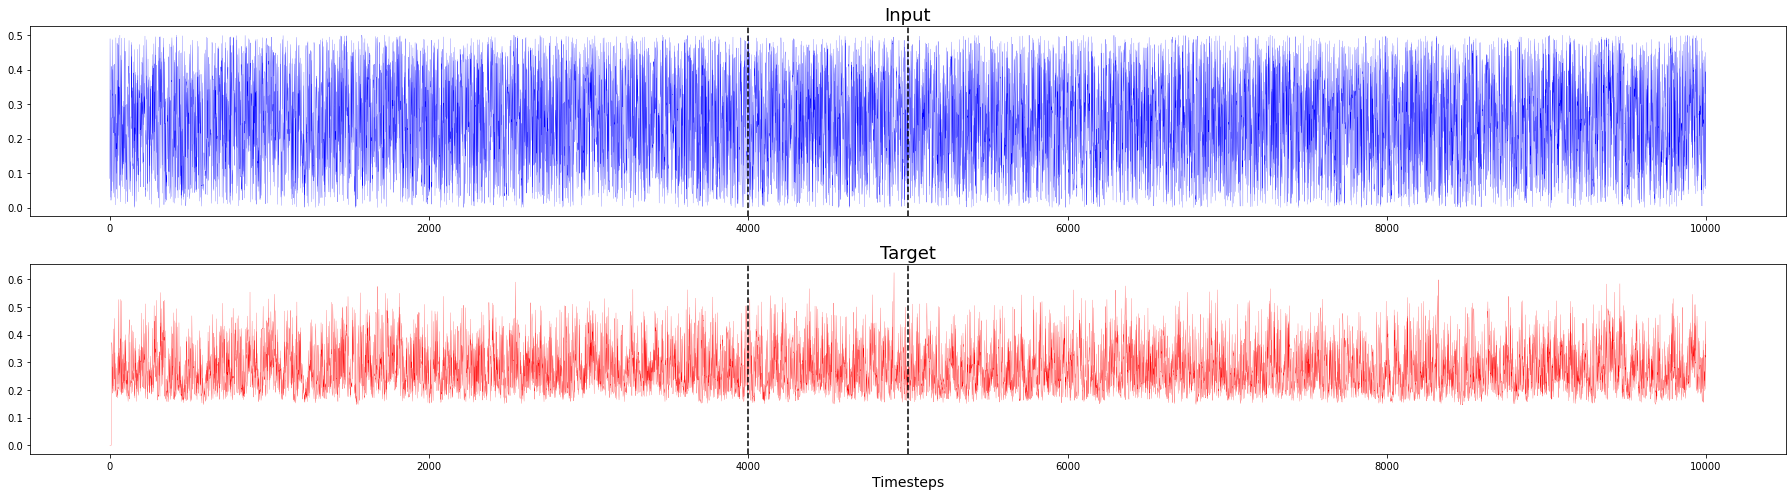

In [13]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

## Reservoir

In [14]:
def esn (hyperparams, plot=False, ntrials=1, test=False, steps_to_plot=200, save = False):
    Nh = int(hyperparams[0])
    rho = hyperparams[1]
    omega_x = hyperparams[2]
    omega_b = hyperparams[3]
    l = hyperparams[4]
    Nx = 1
    dh = 0.1
    dx = 0.1
    db = 0.1 
    valid_mse_hist = []
    for i in range (ntrials):
        # Initialize weights Wx and Wh
        Wx = sparse.rand(Nh, Nx, density=dx)
        Wx.data = 2 * Wx.data - 1
        Wx = omega_x * Wx

        Wh = sparse.rand(Nh, Nh, density=dh)
        Wh.data = 2 * Wh.data - 1
        Wh = Wh.tocoo()   # convert sparse matrix to COOrdinate format
        max_eig = sparse.linalg.eigs(Wh, k=1, return_eigenvectors=False, which='LM')[0]
        Wh *= rho / abs(max_eig)

        # bias 
        b = sparse.rand(Nh, Nx, density=db) #deve corrispondere a Wx??
        b.data = 2 * b.data - 1
        b = omega_b * b

        #print(Wh)
        #print(b)

        #Run the reservoir on the input stream
        #b = np.ones_like(Wx) 


        # Initialize state vector and hidden state history
        state = np.zeros((Nh, 1))
        H = state.copy()


        for t in range(len(x_train)):
            state = np.tanh(Wh.dot(state) + Wx*(x_train[t]) + b)
            H = np.hstack((H, state))


        #discard the washout
        washout_size = 100 #va bene tenerlo costante
        H = H[:, (washout_size+1):]
        Y = y_train[washout_size:]

        #train the readout
        Wo = np.dot(np.dot(Y,H.T),np.linalg.inv(np.dot(H,H.T)+l*np.identity(len(np.dot(H,H.T)))))

        #save the esn variables
        if save == True:
            np.save('Wx',Wx)
            np.save('Wh',Wh)
            np.save('Wo',Wo)
            np.save('b',b)


        o_tr_ = Wo.dot(H)
        o_tr = np.copy(o_tr_)
        o_tr = np.squeeze(o_tr)


        err_tr = mean_squared_error(Y, o_tr)

        if plot == True :    
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'TRAINING - MSE = {err_tr}')
            plt.plot(o_tr, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(Y, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_tr[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(Y[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('training.pdf')

        H = state

        for t in range(len(x_valid)):
            state = np.tanh(Wh.dot(state) + Wx*(x_valid[t]) + b)
            H = np.hstack((H, state))

        H = H[:, 1:]

        o_valid_ = np.dot(Wo, H)
        o_valid = np.copy(o_valid_)
        o_valid = np.squeeze(o_valid)

        err_valid = mean_squared_error(y_valid, o_valid)

        if plot == True:
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'VALIDATION - MSE = {err_valid}')
            plt.plot(o_valid, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(y_valid, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_valid[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(y_valid[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('validation.pdf')
        

        valid_mse_hist.append(err_valid)

        #test
        if test == True:
            H = state

            for t in range(len(x_test)):
                state = np.tanh(Wh.dot(state) + Wx*(x_test[t]) + b)
                H = np.hstack((H, state))

            H = H[:, 1:]

            o_test_ = np.dot(Wo, H)
            o_test = np.copy(o_test)
            o_test = np.squeeze(o_test)
            
            err_test = mean_squared_error(y_test, o_test)

            if plot == True:
                plt.figure(figsize = (25,7))
                plt.subplot(211)
                plt.title(f'VALIDATION - MSE = {err_test}')
                plt.plot(o_test, color = 'r', linewidth = 0.3, label='Output')
                plt.plot(y_test, color = 'black', linewidth = 0.3, label='Target')
                plt.legend()
                plt.subplot(212)
                plt.title(f'First {steps_to_plot} steps')
                plt.plot(o_test[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
                plt.plot(y_test[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
                plt.legend()
                plt.savefig('test.pdf')
        

    avg_val_mse = np.mean(valid_mse_hist)
    #print(f'average validation mse = {avg_val_mse}')
    return avg_val_mse

In [15]:
# anche il bias deve essere sparse?

#hyperparameters
Nh = [50,100,150,200] #number of reservoir units
rho = [0.2,0.5,0.9,0.99,1.1,1.3] #spectral radius
omega_x = [0.01,0.1,1,2] #?? #input scaling
omega_b = [0.01,0.1,1,2] #?? #bias scaling
l = [0.01,0.1,1] #lambda tickhonov regularization coefficient




#compute all the possible combinations
p = np.array(np.meshgrid(Nh, rho, omega_x, omega_b, l)).T.reshape(-1,5)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')
dim_search_space = len(p)

The search space is composed of 1152 combinations of hyperparameters


In [16]:
best_hp = np.load('best_hyperparams.npy')
min_mae= np.load('min_mae.npy')

for i in range(len(p)):
    hyperparameters = p[i,:]
    mae = esn(hyperparameters, ntrials=3)
    if mae < min_mae:
        min_mae = mae
        best_hp = hyperparameters
    print(f'iteration {i}/{dim_search_space}, mae = {mae},hyperparams = {hyperparameters}, best mae so far = {min_mae}')

print(f' BEST HYPERPARAMS{best_hp} corresponding to mae = {min_mae}')
#save the best hyperparameters found
np.save('best_hyperparams',best_hp)
np.save('min_mae',min_mae)

iteration 0/1152, mae = 0.007316239736854545,hyperparams = [5.e+01 2.e-01 1.e-02 1.e-02 1.e-02], best mae so far = 0.0044769311673229
iteration 1/1152, mae = 0.0068973885526517386,hyperparams = [5.e+01 5.e-01 1.e-02 1.e-02 1.e-02], best mae so far = 0.0044769311673229
iteration 2/1152, mae = 0.004979314276992506,hyperparams = [5.e+01 9.e-01 1.e-02 1.e-02 1.e-02], best mae so far = 0.0044769311673229
iteration 3/1152, mae = 0.0042419847098333656,hyperparams = [5.0e+01 9.9e-01 1.0e-02 1.0e-02 1.0e-02], best mae so far = 0.0042419847098333656
iteration 4/1152, mae = 0.007079777874936248,hyperparams = [5.0e+01 1.1e+00 1.0e-02 1.0e-02 1.0e-02], best mae so far = 0.0042419847098333656
iteration 5/1152, mae = 0.006739940352470659,hyperparams = [5.0e+01 1.3e+00 1.0e-02 1.0e-02 1.0e-02], best mae so far = 0.0042419847098333656


ArpackNoConvergence: ARPACK error -1: No convergence (1001 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
#to load esn variables
'''
Wx = np.load('Wx.npy')
Wh = np.load('Wh.npy')
Wo = np.load('Wo.npy')
b  = np.load('b.npy')
'''

"\nWx = np.load('Wx.npy')\nWh = np.load('Wh.npy')\nWo = np.load('Wo.npy')\nb  = np.load('b.npy')\n"

[100.     0.99   1.     0.1    0.1 ]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.043773   ...  0.          0.
   0.        ]
 [ 0.          0.         -0.06281574 ...  0.          0.
   0.        ]]
[[ 0.        ]
 [ 0.        ]
 [ 0.07889734]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.01198428]
 [ 0.02845956]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.04339763]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.    

0.001497605702528014

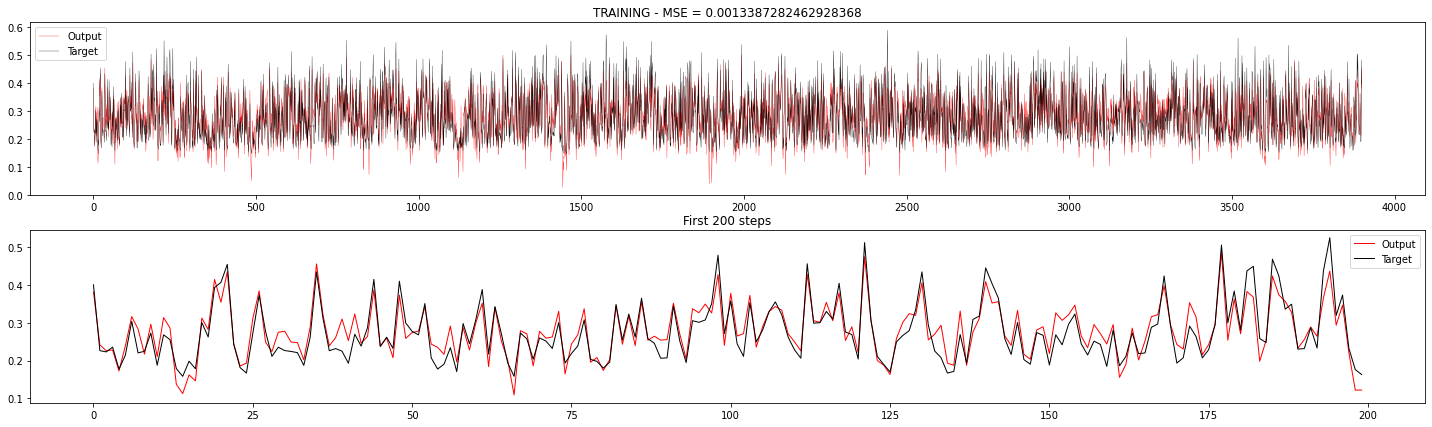

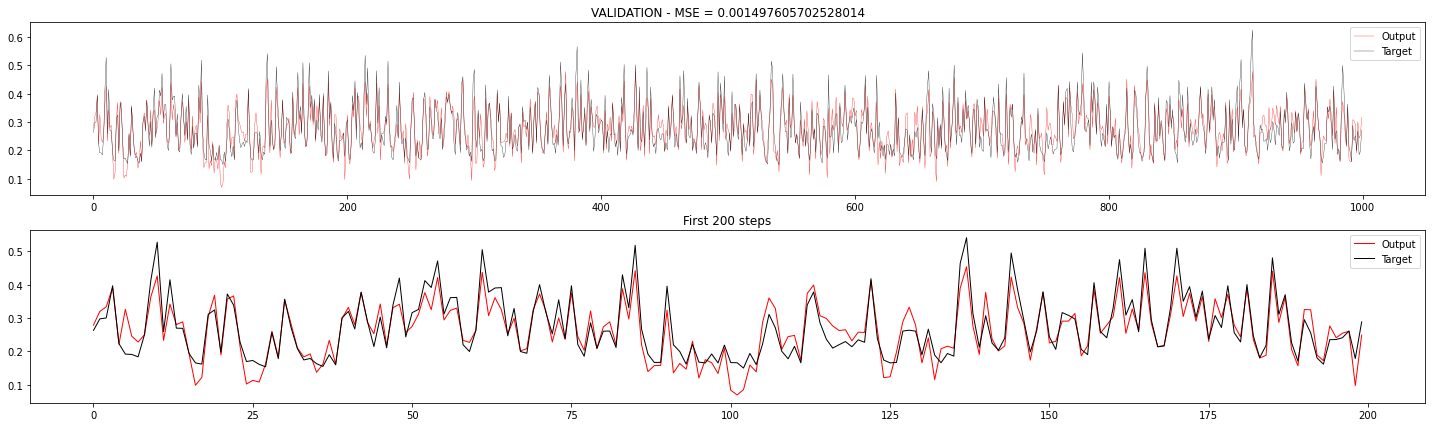

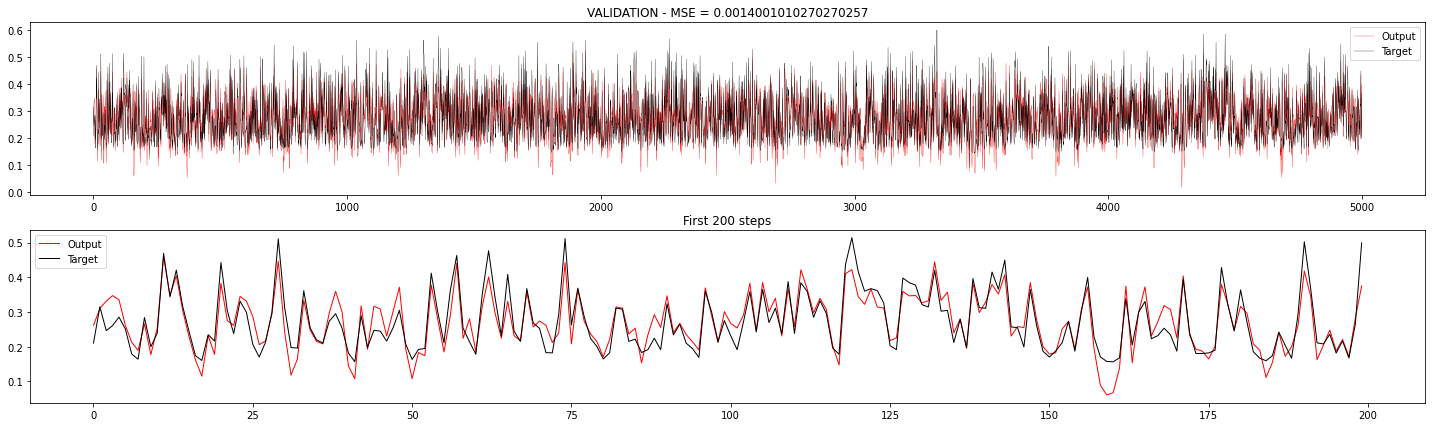

In [ ]:
best_hp = np.load('best_hyperparams.npy')
print(best_hp)
esn(best_hp,plot=True,test=True, save=True)
